In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg as pg
import numpy as np
import json

In [2]:
# Connect to PostgreSQL database using psycopg3

# Load Database Configuration from config.json
with open("config.json", "r") as file:
    config = json.load(file)

# Database Connection Setup
connection = pg.connect(
    host=config["DB_HOST"],
    port=config["DB_PORT"],
    user=config["DB_USER"],
    password=config["DB_PASS"],
    dbname=config["DB_NAME"]
)


In [3]:
# Query to generate the binary bitmap directly from the database
query = """
WITH time_intervals AS (
    -- Generate a series of 10-minute intervals for the entire day
    SELECT generate_series(
        '2024-03-01 00:00:00'::timestamp,
        '2024-03-01 23:59:59'::timestamp,
        '10 minute'::interval
    ) AS time_bin
),
observations AS (
    -- Get distinct MMSI and corresponding observation times
    SELECT MMSI, date_bin('10 minutes', T, TIMESTAMP '2024-03-01 00:00:00'::timestamp) AS observation_bin
    FROM AISInputTarget
    WHERE T >= '2024-03-01 00:00:00' AND T <= '2024-03-01 23:59:59'
)
-- Create the matrix where each cell represents whether an observation exists (0) or is empty (1)
SELECT mmsi_ids.MMSI, time_intervals.time_bin,
    COUNT(observations.observation_bin) > 0 AS has_observations
FROM
    (SELECT DISTINCT MMSI FROM AISInput) AS mmsi_ids
    CROSS JOIN time_intervals
    LEFT JOIN observations ON mmsi_ids.MMSI = observations.MMSI AND time_intervals.time_bin = observations.observation_bin
GROUP BY mmsi_ids.
MMSI, time_intervals.time_bin;
"""

In [4]:
# Load the data into a pandas DataFrame
df = pd.read_sql_query(query, connection)

# Close the connection
connection.close()

/tmp/ipykernel_70131/3663969895.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [5]:
df

,mmsi,time_bin,has_observations
0,174,2024-03-01 00:00:00,False
1,174,2024-03-01 00:10:00,False
2,174,2024-03-01 00:20:00,False
3,174,2024-03-01 00:30:00,False
4,174,2024-03-01 00:40:00,False
...,...,...,...
456331,1058600528,2024-03-01 23:10:00,False
456332,1058600528,2024-03-01 23:20:00,False
456333,1058600528,2024-03-01 23:30:00,False
456334,1058600528,2024-03-01 23:40:00,False


/tmp/ipykernel_70131/996245063.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', 2)  # Red-Yellow-Green colormap with two discrete colors


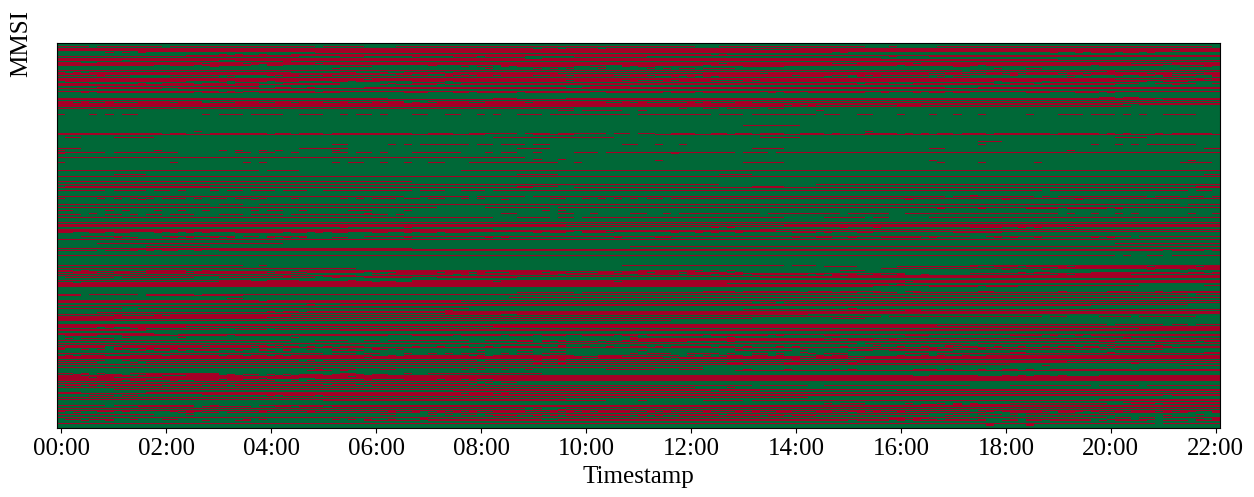

In [6]:
# Sample DataFrame creation (replace with your actual data)
# df = pd.DataFrame(...) # Your original dataframe here

# Pivot the DataFrame to create a matrix for visualization
pivot_df = df.pivot(index='mmsi', columns='time_bin', values='has_observations')

# Convert the pivot table to a numpy array (matrix)
bitmap_matrix = pivot_df.to_numpy()

# Create the plot
plt.figure(figsize=(15, 5))

# Use a binary colormap: red for 1 (empty), green for 0 (observed)
cmap = plt.cm.get_cmap('RdYlGn', 2)  # Red-Yellow-Green colormap with two discrete colors
plt.imshow(bitmap_matrix, aspect='auto', cmap=cmap, interpolation='none')

# Set font properties
font = {'family': 'Liberation Serif',
        'size': 18,
        'color': 'black'}

# Add labels with custom fonts
plt.xlabel('Timestamp', fontdict=font)
plt.ylabel('MMSI', fontdict=font)

# Customize x-axis labels for readability
n_ticks = 12  # Number of ticks to show on x-axis
timestamps = pivot_df.columns
plt.xticks(np.linspace(0, len(timestamps) - 1, n_ticks), 
           pd.to_datetime(timestamps[::len(timestamps)//n_ticks]).strftime('%H:%M'), fontdict=font)

# Suppress y-axis labels to avoid overcrowding
plt.gca().yaxis.set_visible(False)

# Add an axis title for MMSI outside the y-axis
plt.text(-5, 0, 'MMSI', va='center', ha='center', fontdict=font, rotation=90)

# Save the heatmap as a PDF with zero margins
plt.savefig("AISGaps.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

# Display the plot in a viewer
plt.show()
